In [60]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib
from tqdm import tqdm
import copy
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import matplotlib.ticker as ticker


In [61]:
def open_pkl(file_path):
    with open(file_path, 'rb') as f:
        pkl_obj = pickle.load(f)
    
    return pkl_obj

In [62]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    cmap2 = copy.copy(cm.YlGn)
    cmap2.set_under('snow')
    # cmap2.set_over('green')
    bounds = np.linspace(0.1, 1, 10)
    # norm2 = mcolors.Normalize(vmin=0, vmax=1)
    norm2 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')
    im = ax.imshow(data, cmap=cmap2, norm=norm2, **kwargs)

    # Create colorbar
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad="3%")

    cbar = ax.figure.colorbar(im, cax=cax, ax=ax, extend='both', ticks=np.linspace(0.1, 1, 10), **cbar_kw)
    # cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    cbar.ax.set_ylabel(cbarlabel, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, size=14, fontproperties = 'Times New Roman') # , rotation='vertical'
    ax.set_xlabel('播种后天数\n$\mathrm{Days}$ $\mathrm{after}$ $\mathrm{sowing}$',size=18, linespacing=1.5)
    ax.set_ylabel('作物参数\n$\mathrm{Crop}$ $\mathrm{parameters}$',size=18, linespacing=1.5)
    # ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, size=12, fontproperties = 'Times New Roman')

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-75, ha="left",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [63]:
font_options = {'family': 'serif', 'serif': 'Simsun',}
plt.rc('font', **font_options)

In [64]:
matplotlib.rcParams.update({'font.family': 'sans', 'mathtext.fontset': 'stix', 'text.usetex': False})
plt.rcParams['font.sans-serif']=['Simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
font_dict={'family' : 'Times New Roman', 'size'   : 12}

In [65]:
def isdir_demo(dir_path):
    if not os.path.isdir(dir_path):
        try:
            os.mkdir(dir_path)
        except FileNotFoundError:
            os.makedirs(dir_path)
            

In [80]:
import yaml
def correct_var(df):
    # name_dict = {
    #     "SLATB1": "SLATB0.00", "SLATB2": "SLATB1.00",
    #     "SLATB3": "SLATB2.00", "EFFTB1": "EFTB0",
    #     "EFFTB2": "EFFTB40", "AMAXTB125": "AMAXTB1.25",
    #     "AMAXTB150": "AMAXTB1.50", "AMAXTB175": "AMAXTB1.75",
    #     "AMAXTB000": "AMAXTB0.00", "AMAXTB200": "AMAXTB2.00",
    #     "RFSETB0": "RFSETB0.00", "RFSETB2": "RFSETB2.00",
    #     "SLATB001": "SLATB0.00", "SLATB003": "SLATB0.78",
    #     "SLATB005": "SLATB2.00", "KDIFTB001": "KDIFTB0.0",
    #     "KDIFTB003": "KDIFTB2.0", "EFFTB001": "EFFTB0.0",
    #     "EFFTB003": "EFFTB40.0", "AMAXTB001": "AMAXTB0.00",
    #     "AMAXTB003": "AMAXTB1.25", "AMAXTB005": "AMAXTB1.50",
    #     "AMAXTB007": "AMAXTB1.75", "AMAXTB009": "AMAXTB2.00",
    #     "TMPFTB001": "TMPFTB0.00", "TMPFTB007": "TMPFTB30.0",
    #     "TMNFTB003": "TMNFTB8.0", "RFSETB001": "RFSETB0.00",
    #     "RFSETB007": "RFSETB2.00", "FLTB001": "FLTB0.00",
    #     "FLTB003": "FLTB0.33", "FLTB005": "FLTB0.88",
    #     "FLTB007": "FLTB0.95", "FLTB009": "FLTB1.10",
    #     "FOTB009": "FOTB1.10", "TBASEM": "TBASE"
    # }
    with open("./parametersName.yaml", "r") as f:
        name_dict = yaml.safe_load(f)
    if isinstance(df, pd.DataFrame):
        tmp_df = df.copy()
        tmp_df["id"] = 100
        i = df['Parameter'].shape[0]
        j = 0
        for idx in range(i):
            tmp_str = df['Parameter'][idx]
            try:
                tmp_df.loc[idx, 'Parameter'] = name_dict[tmp_str][0]
                tmp_df.loc[idx, 'id'] = name_dict[tmp_str][1]
            except KeyError:
                tmp_df.loc[idx, 'id'] = i + j
                j += 1
        tmp_df.set_index("id", inplace=True, drop=True)
        tmp_df.sort_index(inplace=True)
        return tmp_df
    elif isinstance(df, (list, tuple)):
        tmp_list = list()
        for each in df:
            try:
                tmp_list.append(name_dict[each][0])
            except Exception:
                tmp_list.append(each)
        return tmp_list
    else:
        print("仅支持pd.DataFrame、tuple、list类型")
        return None

# 最终产量 生物量 LAIMAX绘图代码

In [90]:
def draw_demo(df1, path_save=None):
    Y1, Y2 = df1["First_order"], df1["Total_order"]
    var_name = df1["Parameter"]
    num_var = Y1.shape[0]
    x = np.arange(num_var)
    total_width, n = 0.8, 2
    width = total_width / n
    x = x - (total_width - width) / 2
    x_labels = var_name.tolist()
    fig, ax = plt.subplots(figsize=(12, 6))
    # 去除边框
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.bar(x, Y1, width=width, label="一阶敏感性指数")
    ax.bar(x+width, Y2, width=width, label="全局敏感性指数")
    ax.axhline(y=0.1, linestyle=(0, (10, 6)), color='r', label="0.1参考线", lw=0.9)
    ax.axhline(y=0.05, linestyle=(0, (10, 6)), color='b', label="0.05参考线", lw=0.9)
    ax.set_xlim(x[0] - 1.5 * width, x[-1] + 2.5 * width)
    # 设置x轴刻度 size设置字体大小，fontproperties设置字体样式
    ax.set_xticks(width/2+x, x_labels, fontproperties = 'Times New Roman', size=10, rotation='vertical')
    # 设置y轴刻度的字体和大小
    yticks = ax.get_yticks()
    y_label = [f"{i:<.2f}" for i in yticks]
    ax.set_yticks(yticks, y_label, fontproperties = 'Times New Roman', size=12)
    # 设置y轴 16单位是像素  相当于word中的小四
    ax.set_ylabel('敏感性指数\n$\mathrm{Sensity}$ $\mathrm{Index}$',size=14, linespacing=1.5)
    ax.set_xlabel('作物参数\n$\mathrm{Parameters}$',size=14)
    # label显示在右外侧
    # ax.legend(fontsize=13,loc=9, bbox_to_anchor=(1.05, 0.5),prop={'family':'Times New Roman'})
    ax.legend(prop={'family':'Simsun', 'size': 12})
    if path_save is None:
        pass
    else:
        # 解决导出svg格式的时候，图片外侧显示不全的问题
        # fig.subplots_adjust(right=0.75)
        plt.savefig(path_save, format="svg", dpi=750, bbox_inches = 'tight')
    plt.close(fig)

In [87]:
def df_mean(df1, df2):
    return (df1 + df2) / 2.0

In [69]:
n_amout = [180]
col1 = ["LAIMAX", "TAGP", "TWSO", "id"]
col2 = ["LAI", "TAGP", "id"]
root_dir = "./data/modelOut/NWLP1/Siraw/"
save_dir = "./data/modelOut/NWLP1/Siraw/mean/"
isdir_demo(save_dir)
for type_name in ["PPN"]:
    for var_name in col1[: -1]:
        for ni in n_amout:
            file_name1 = f"{type_name}{ni}2021_{var_name}_0.csv"
            file_name2 = f"{type_name}{ni}2022_{var_name}_0.csv"
            df1 = pd.read_csv(os.path.join(root_dir, file_name1), header=0, index_col=0)
            df2 = pd.read_csv(os.path.join(root_dir, file_name2), header=0, index_col=0)
            df = df_mean(df1, df2)
            df.to_csv(os.path.join(save_dir, f"{type_name}{ni}_{var_name}.csv"))

In [91]:
r_dir = "./data/modelOut/NWLP1/Siraw/mean/"
for root_dir, _, name_list in os.walk(r_dir):
    if len(name_list) == 0:
        continue

    for name in tqdm(name_list):
        tmp_name = name.split(".")[0]
        var_name = tmp_name.split("_")[-1]
        save_dir = f"./img/NWLP/{var_name}/"
        isdir_demo(save_dir)
        save_name = os.path.join(save_dir, f"{tmp_name}_42.svg")
        tmp_df = pd.read_csv(os.path.join(root_dir, name))
        tmp_df = correct_var(tmp_df)
        draw_demo(tmp_df, save_name)

100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


# 时间序列LAI 生物量绘图代码

In [71]:
conn = sqlite3.connect("./data/modelOut/NWLP1/Siraw/LAI_ori.db")
conn1 = sqlite3.connect("./data/modelOut/NWLP1/Siraw/LAI.db")

In [51]:
# from datetime import timedelta, datetime
#
# a = datetime(2021, 6, 12)
# b = datetime(2021, 6, 11)
# c = timedelta(days=110)
# print(a + timedelta(days=115))
# print(b + timedelta(days=115))

In [72]:
sql_cmd = "SELECT Parameter, First_order, Total_order FROM PPN0LAI WHERE PPN0LAI.DOY = 20 AND PPN0LAI.YEAR = 2021"
df_test = pd.read_sql(sql=sql_cmd, con=conn, index_col="Parameter")

DatabaseError: Execution failed on sql 'SELECT Parameter, First_order, Total_order FROM PPN0LAI WHERE PPN0LAI.DOY = 20 AND PPN0LAI.YEAR = 2021': no such table: PPN0LAI

In [73]:
table_list = list()

for nn in ["PPN"]:
    for ni in [180]:
        for var in ["LAI", "TAGP"]:
            table_list.append(f"{nn}{ni}{var}")


In [74]:
# DOY 10~121 距6月11的天数
doy_list = range(10, 115)
total = len(table_list) * len(doy_list)

In [75]:
with tqdm(total=total) as pbar:
    pbar.set_description('Processing: ')
    for table_name in table_list:
        df_first = pd.DataFrame(index=df_test.index, columns=[str(xx) for xx in doy_list])
        df_total = pd.DataFrame(index=df_test.index, columns=[str(xx) for xx in doy_list])
        for doy in doy_list:
            sql_cmd1 = f"SELECT Parameter, First_order, Total_order FROM {table_name} WHERE {table_name}.DOY = {doy + 1} AND {table_name}.YEAR = 2021"
            sql_cmd2 = f"SELECT Parameter, First_order, Total_order FROM {table_name} WHERE {table_name}.DOY = {doy} AND {table_name}.YEAR = 2022"
            df1 = pd.read_sql(sql=sql_cmd1, con=conn, index_col="Parameter")
            df2 = pd.read_sql(sql=sql_cmd2, con=conn, index_col="Parameter")
            flag1 = np.all(df1.isnull())
            flag2 = np.all(df2.isnull())
            if flag1 and flag2:
                pass
            else:
                df1, df2 = df1.fillna(value=np.nan), df2.fillna(value=np.nan)
                col_name = str(doy)
                for each in df1.index:
                    df_first.loc[each, col_name] = np.nanmean([df1.loc[each, "First_order"], df2.loc[each, "First_order"]])
                    df_total.loc[each, col_name] = np.nanmean([df1.loc[each, "Total_order"], df2.loc[each, "Total_order"]])
            pbar.update(1)
        df_first.to_sql(f"{table_name}S1", con=conn1, chunksize=10000, if_exists='append')
        df_total.to_sql(f"{table_name}ST", con=conn1, chunksize=10000, if_exists='append')


Processing: : 100%|██████████| 210/210 [00:04<00:00, 47.86it/s]


In [76]:
conn.close()
conn1.close()

## 绘图开始

In [77]:

conn1 = sqlite3.connect("./data/modelOut/NWLP1/Siraw/LAI.db")

In [41]:

# df_test.dropna(axis=1, thresh=20, inplace=True)

In [42]:
# df11 = df_test.iloc[:int(34/2), :]
# df22 = df_test.iloc[int(34/2): , :]

In [43]:
51/34

1.5

In [78]:
table_list = list()
for i1 in ["PPN"]:
    for ni in [180]:
        table_list.append(f"{i1}{ni}LAIST")
        table_list.append(f"{i1}{ni}TAGPST")


In [84]:
path_save = f"./img/NWLP/timeSeries/"
isdir_demo(path_save)
for table_name in tqdm(table_list):
    sql_cmd = "SELECT * FROM %s" % table_name
    df_test = pd.read_sql(sql=sql_cmd, con=conn1, index_col="Parameter")
    df_test = df_test.loc[:, [str(i) for i in range(10, 111, 2)]]
    df_test.fillna(0, inplace=True)
    parameters = df_test.index.tolist()
    parameters = correct_var(parameters)
    doys = df_test.columns.tolist()
    data = df_test.to_numpy()
    fig, ax = plt.subplots(figsize=(12, 12))
    im, cbar = heatmap(data, parameters, doys, ax=ax)
    # texts = annotate_heatmap(im, valfmt="{x:.1f} t")
    fig.tight_layout()
    # plt.show()

    if path_save is None:
        pass
    else:
        # 解决导出svg格式的时候，图片外侧显示不全的问题
        # fig.subplots_adjust(right=0.75)
        path_save1 = os.path.join(path_save, f"40_{table_name}.svg")
        plt.savefig(path_save1, format="svg", dpi=750, bbox_inches = 'tight')
    plt.close(fig)

100%|██████████| 2/2 [00:21<00:00, 10.52s/it]


In [20]:
table_name = "WLPN180TAGPST"
sql_cmd = "SELECT * FROM %s" % table_name
df_LAI = pd.read_sql(sql=sql_cmd, con=conn1, index_col="Parameter")
df_LAI.reset_index(inplace=True)
df_LAI = correct_var(df_LAI)
df_LAI.set_index("Parameter", drop=True, inplace=True)

In [21]:
# parameter_names = ["SLATB0.00", "SPAN", "TMNFTB8.0", "TEFFMX", "TDWI", "EFFTB40.0", "FLTB0.00", "FLTB0.33"] ## LAI用
parameter_names = ["SLATB0.00", "TMNFTB8.0", "TEFFMX", "TDWI", "EFFTB40.0", "CVL", "CVS", "FLTB0.33"]
df_draw = df_LAI.loc[parameter_names, [str(x) for x in range(20, 115)]]

In [22]:
row, col = df_draw.shape
df_draw2 = df_draw.iloc[: int(row / 2), :]
df_draw1 = df_draw.iloc[int(row / 2): , :]

In [23]:
df_draw2

,20,21,22,23,24,25,26,27,28,29,...,105,106,107,108,109,110,111,112,113,114
Parameter,,,,,,,,,,,,,,,,,,,,,
SLATB0.00,0.026464,0.065213,0.121959,0.191435,0.255565,0.300327,0.338502,0.381578,0.418132,0.446874,...,0.275785,0.274775,0.273422,0.272156,0.271394,0.270792,0.270444,0.270206,0.270080,None
TMNFTB8.0,0.021801,0.053746,0.107340,0.182162,0.259248,0.318194,0.377753,0.450187,0.512431,0.564170,...,0.728744,0.727565,0.725660,0.723708,0.722361,0.720939,0.719498,0.718021,0.717250,None
TEFFMX,0.112668,0.225113,0.329829,0.403905,0.434680,0.439700,0.432068,0.420631,0.405948,0.388039,...,0.017648,0.017491,0.017093,0.016740,0.016712,0.016693,0.016649,0.016615,0.016611,None
TDWI,0.815468,0.609493,0.416073,0.274598,0.202509,0.166779,0.141964,0.116906,0.097214,0.080751,...,0.007088,0.007001,0.006874,0.006749,0.006665,0.006585,0.006513,0.006452,0.006424,None


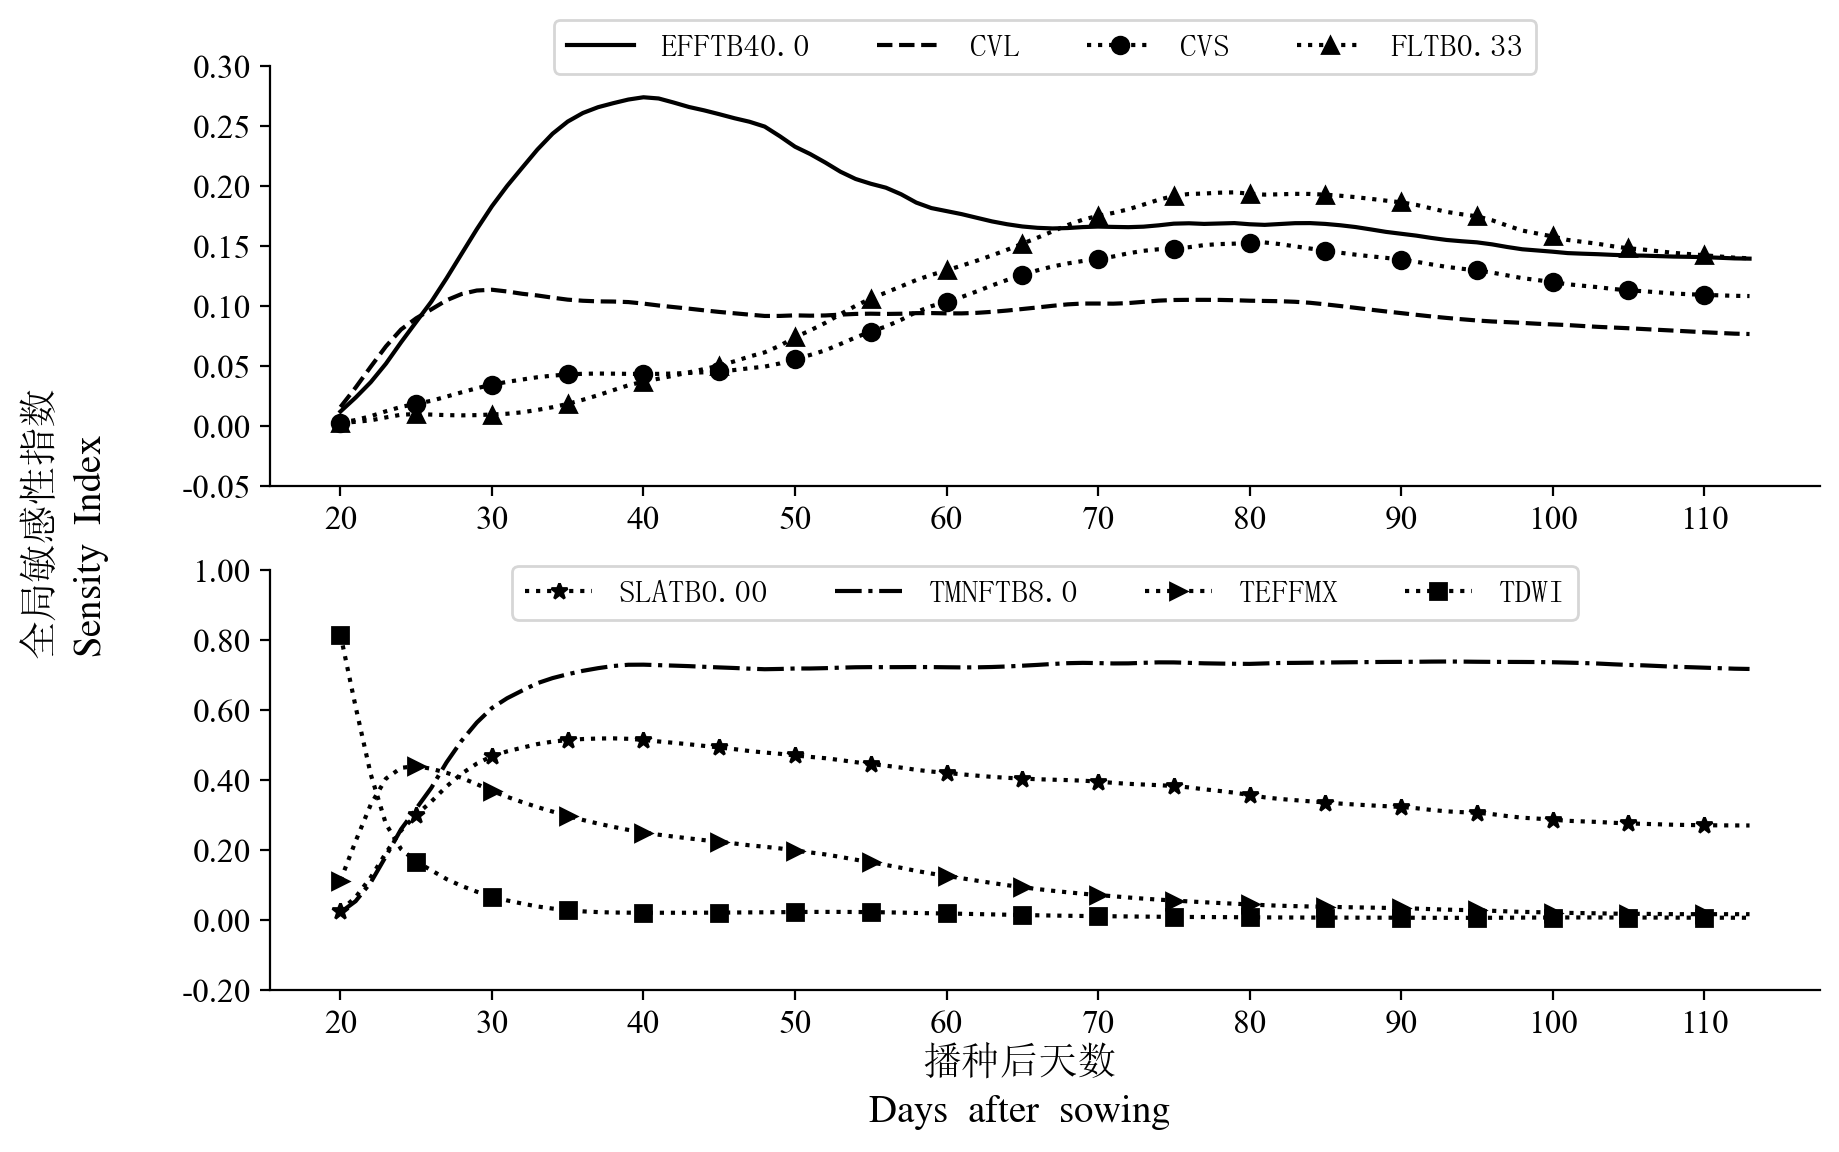

In [25]:
df_draw = df_draw1
markers = [["-", "--", "o:", "^:"], ["*:", "-.", ">:", "s:"]]
path_save1 = "./img/Final_new/timeSeries/plot_TAWG01.svg"
# makers = gen_marker(len(parameter_names))
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
for df_draw, marker, ax in zip([df_draw1, df_draw2], markers, axes):
    draw_x = df_draw.columns.to_numpy()
    
    # 去除边框
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    i = 0
    for para in df_draw.index:
        draw_y = df_draw.loc[para, :]
        ax.plot(draw_x, draw_y, marker[i], color="k", label=para, linewidth=1.5, markevery=5)
        i += 1
    
# 设置x轴刻度 size设置字体大小，fontproperties设置字体样式
# ax.set_xlim(15, 115)
# ax.set_ylim(0, 0.45)

    xticks = ax.get_xticks()
    x_lable = [f"{i + 20}" for i in xticks]
    ax.set_xticks(xticks, x_lable, fontproperties = 'Times New Roman', size=12)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    # 设置y轴刻度的字体和大小
    yticks = ax.get_yticks()
    y_label = [f"{i:<.2f}" for i in yticks]
    ax.set_yticks(yticks, y_label, fontproperties = 'Times New Roman', size=12)
    # 设置y轴 16单位是像素  相当于word中的小四
    # ax.set_ylabel('全局敏感性指数\n$\mathrm{Sensity}$ $\mathrm{Index}$',size=14, linespacing=1.5)
    # ax.set_xlabel('播种后天数\n$\mathrm{Days}$ $\mathrm{after}$ $\mathrm{sowing}$',size=14, linespacing=1.5)
    # label显示在右外侧
    # ax.legend(fontsize=13,loc=9, bbox_to_anchor=(1.05, 0.5),prop={'family':'Times New Roman'})
    
axes[0].legend(prop={'family':'Simsun', 'size': 12}, ncol=4, loc="upper center", bbox_to_anchor=(0.25, 0.65, 0.5, 0.5))
axes[1].legend(prop={'family':'Simsun', 'size': 12}, ncol=4, loc="upper center", bbox_to_anchor=(0.25, 0.55, 0.5, 0.5))

fig.text(0.5, 0, '播种后天数\n$\mathrm{Days}$ $\mathrm{after}$ $\mathrm{sowing}$', size=14, linespacing=1.5, ha='center')
fig.text(0, 0.5, '全局敏感性指数\n$\mathrm{Sensity}$ $\mathrm{Index}$', size=14, linespacing=1.5, va='center', rotation='vertical')
# fig.legend(prop={'family':'Simsun', 'size': 12}, ncol=4, loc="upper center", bbox_to_anchor=(0.25, 0.65, 0.5, 0.5))
plt.savefig(path_save1, format="svg", dpi=750, bbox_inches = 'tight')


In [124]:
draw_x

array(['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
       '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52',
       '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63',
       '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74',
       '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85',
       '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96',
       '97', '98', '99', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '110', '111', '112', '113', '114'],
      dtype=object)